In [1]:
using LinearAlgebra, Plots

## Optimal Fishing Effort

#### Minimization problem: 
$\quad$ $\min_u{g(\textbf{x}(T))}$ subject to $\frac{d\textbf{x}}{dt} = \textbf{F}(\textbf{x}(t), \textbf{u}(t))$, $x(0) = x_0$
#### where
$\quad$ $\textbf{F}(\textbf{x}(t), \textbf{u}(t)) = \begin{bmatrix} \alpha f(f_{max}-f)-\beta f u \\ \delta m + \beta f u \end{bmatrix} \;$ , $\beta = 1, f_{max}=f_{0}=1$


#### Where our objective function is 
$\quad$ $g(\begin{bmatrix} f \\ m\end{bmatrix}) = -m(T)$

#### And the gradient is 
$\quad$ $\nabla g(\begin{bmatrix} f \\ m\end{bmatrix}) = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$

In [2]:
function F(t::Any,xv::Vector{Float64}, u::Float64, params::Dict{String,Real})
    f = xv[1]
    m = xv[2]
    alpha = get(params,"alpha",0.1)
    beta = get(params,"beta",0.5)
    delta = get(params,"delta",0.05)
    
    return [
        alpha * f * (1 - f) - beta * f * u, 
        delta * m + beta * f * u
    ]
end

function dg(x::Any)
    return [
        0,
        1
    ]
end

dg (generic function with 1 method)

#### Derivative of $\textbf{F}$ with respect to $\textbf{x}$
$\quad$ $\nabla_{x} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} \alpha -2 \alpha f - u  && 0  \\ u  && \delta \end{bmatrix}$

In [22]:
function jacF(xv::Vector{Float64}, u::Float64, params::Dict{String,Real})
    alpha = get(params,"alpha",0.1)
    beta = get(params,"beta",0.5)
    delta = get(params,"delta",0.05)

    f, _ = xv
    return [-alpha * (1 - 2*f) + beta * u  beta * f;  
            beta * u                       delta]
end

jacF (generic function with 1 method)

#### Derivative of $\textbf{F}$ with respect to $\textbf{u}$
$\quad$ $\nabla_{u} \textbf{F}(t, \textbf{x}, \textbf{u}) = \begin{bmatrix} -\beta f \\ \beta f \end{bmatrix}$

In [4]:
function dFdu(x::Vector{Float64}, u::Float64, params::Dict{String,Real})
    f = x[1]
    alpha = get(params,"alpha",0.1)
    beta = get(params,"beta",0.5)
    delta = get(params,"delta",0.05)

    return [
        -beta * f,
        beta * f
    ]
end

dFdu (generic function with 1 method)

#### Discretization via Euler's Method
$\quad$ $\textbf{x}_{k+1} = \textbf{x} + h\textbf{F}(\textbf{x}_{k},\textbf{u}_{k})$

This allows us to find $\textbf{x}(T)$ via a forward pass

In [5]:
function forward(x0::Vector{Float64}, t0::Float64, F::Function, u::Vector{Float64}, params::Dict{String,Real})
    N = length(u)
    xs = zeros(eltype(x0), N+1, length(x0))
    xs[1, :] = x0
    h = get(params,"h",0.1)
    for i in 1:N
        t = t0 + h*i
        xs[i+1, :] = xs[i, :] + h*F(t, xs[i, :], u[i],params)
    end
    return xs
end

forward (generic function with 1 method)

#### Lagrange Multiplier Equations
$\quad$ $\lambda_{k-1} = \lambda_{k} + h\nabla_{x} \textbf{F}(\textbf{x}_k, \textbf{u}_k)^T \lambda$

Moving backwards from the last $\lambda$ fills in the rest of the $\lambda$'s via a backward pass

In [31]:
function backward(xv, u,grad_g::Function, jacF::Function,params::Dict{String,Real})
    N = size(xv, 1) - 1
    lambdas = zeros(Float64, N, size(xv, 2))
    lambdas[end, :] = dg(xv[end, :])
    h = get(params,"h",0.1)
    for k in N-1:-1:1
        lambdas[k, :] = lambdas[k+1,:] + h * jacF(xv[k+1, :], u[k+1],params)'*lambdas[k+1,:]

    end
    return lambdas
end

backward (generic function with 1 method)

In [63]:
function du(lambdas, xv, u, dFdu::Function,params::Dict{String,Real})
    grad_u = zeros(length(u))
    h = get(params,"h",0.1)
    for k in 1:length(u)
        grad_u[k] = dot(lambdas[k, :], dFdu(xv[k, :], u[k],params)) * h
    end
    return grad_u
end

du (generic function with 3 methods)

In [99]:
function gradient_descent(u, grad_u, step_size, umin, umax)
    u_new = u - step_size * grad_u
    return clamp.(u_new, umin, umax)
end

gradient_descent (generic function with 2 methods)

In [77]:
function line_search(u, d, grad_u, objective_func, c1, alpha, beta, umax, F, x0, t0, h)
    u_new = clamp.(u + alpha * d, -umax, umax)  # Initialize u_new for the first iteration
    G_current = calculate_objective(u, x0, t0, F, h)

    while true
        G_new = calculate_objective(u_new, x0, t0, F, h)
        if G_new <= G_current + c1 * alpha * dot(grad_u, d)
            break  # Sufficient decrease condition met
        end
        alpha *= beta  # Reduce step size
        if alpha < 1e-8  # Avoid infinite loops, ensure that u_new is defined even if loop breaks here
            break
        end
        u_new = clamp.(u + alpha * d, -umax, umax)  # Update u_new within the loop
    end
    return u_new, alpha
end

line_search (generic function with 1 method)

In [94]:
function g(u, x0, t0, F::Function, h)
    xv = forward(x0, t0, F, u, h)
    return states[end, 2]  # Assuming we're minimizing the second state variable at the final time
end

g (generic function with 1 method)

In [97]:
function optimize()
    N = 400  # Number of steps
    T = 40.0  # Total time in years
    h = T / N
    x0 = [1.0, 0.0]  # Initial conditions
    u = fill(0.5, N)  # Start with half the maximum effort
    umin, umax = 0.0, 1.0  # Control limits
    states = nothing
    params = Dict(
        "alpha"=>0.05,
        "beta"=>0.5,
        "delta"=>0.05,
        "umin"=>0.0,
        "umax"=>0.5,
        "N"=>N,
        "h"=>h,
    )
    for iteration in 1:1000
        xv = forward(x0, 0.0, F, u, params)
        lambdas = backward(xv, u, dg, jacF,params)
        grad_u = du(lambdas, xv, u, h, dFdu,params)
        u = gradient_descent(u, grad_u, h, umin, umax)
    end

    return u, states
end

optimize (generic function with 3 methods)

In [98]:
optimize()

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.4999821249088238, 0.499981929193184, 0.4999817634573618, 0.4999816259708532, 0.49998151508481953, 0.49998142922854877, 0.4999813669060466, 0.4999813266927857, 0.4999813072325846, 0.4999813072346106], nothing)

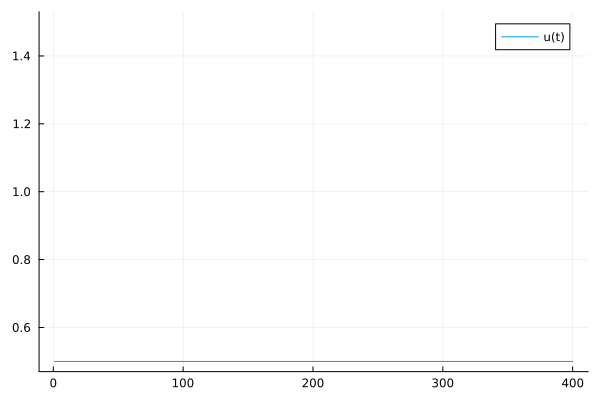

In [93]:
plot(u,label="u(t)")
